In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/creditcardfraud/creditcard.csv


In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score, precision_recall_curve, f1_score, fbeta_score, accuracy_score
from imblearn.under_sampling import RandomUnderSampler
from sklearn import linear_model
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
import sklearn.metrics as metrics
%matplotlib inline
import matplotlib.pyplot as plt

In [6]:
df = pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


/tmp/ipykernel_33/3856033746.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['Time'], color='blue')
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Time', ylabel='Density'>

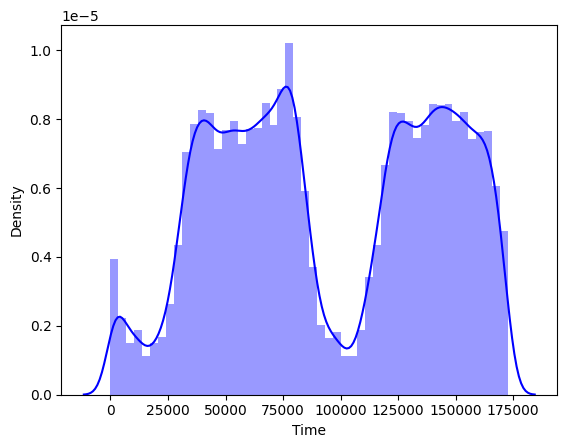

In [7]:
sns.distplot(df['Time'], color='blue')

/tmp/ipykernel_33/1882531635.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['Amount'], color='blue')
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Amount', ylabel='Density'>

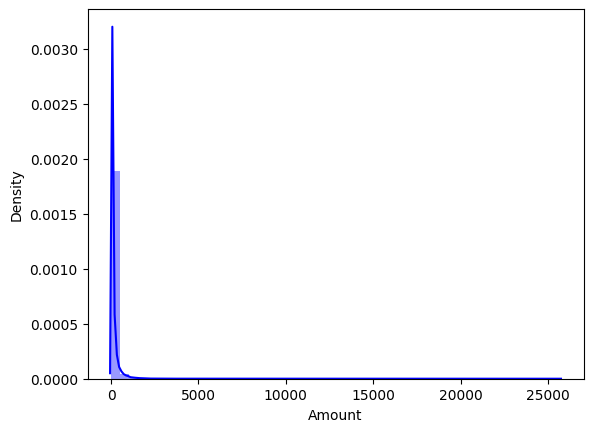

In [8]:
sns.distplot(df['Amount'], color='blue')

In [9]:
fraud = df['Class'].value_counts()[1]
not_fraud = df['Class'].value_counts()[0]
print("Fraud cases: ", fraud)
print("Not fraud cases: ", not_fraud)

Fraud cases:  492
Not fraud cases:  284315


<Axes: xlabel='Class', ylabel='count'>

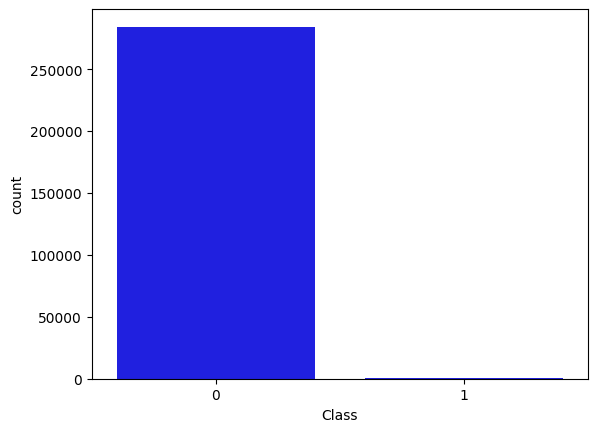

In [10]:
sns.barplot(x = df['Class'].value_counts().index, y = df['Class'].value_counts(), color='blue')

<Axes: >

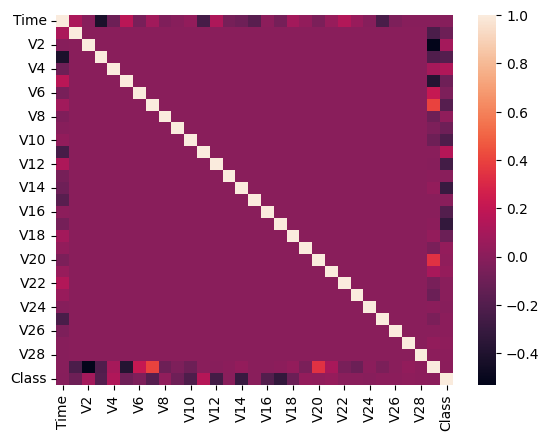

In [11]:
sns.heatmap(data = df.corr())

In [12]:
data = df.drop(columns=['Class'])
answer = df['Class']

In [13]:
X_trainval, X_test, y_trainval, y_test = train_test_split(data, answer, test_size = 0.2,
                                                         stratify = df['Class'],
                                                         random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval,
                                                 test_size = 0.25,
                                                 stratify = y_trainval,
                                                 random_state = 42)
scaler = StandardScaler()
scaler.fit(X_train)

X_train_std = scaler.transform(X_train)
X_val_std = scaler.transform(X_val)
X_test_std = scaler.transform(X_test)

In [14]:
rus = RandomUnderSampler(random_state = 42)

X_train_under, y_train_under = rus.fit_resample(X_train_std, y_train)

X_val_under, y_val_under = rus.fit_resample(X_val_std, y_val)

In [15]:
penalty = ['l2']
C = np.logspace(0, 4, 10, 100, 1000)
param_grid = dict(C=C, penalty=penalty)

logistic = linear_model.LogisticRegression(solver = 'lbfgs', max_iter = 10000)
logistic_grid = GridSearchCV(logistic, param_grid, cv = 5, scoring = 'roc_auc', verbose=10, n_jobs=-1)
logistic_grid.fit(X_train_under, y_train_under)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=10000), n_jobs=-1,
             param_grid={'C': array([1.00000000e+00, 2.15443469e+01, 4.64158883e+02, 1.00000000e+04,
       2.15443469e+05, 4.64158883e+06, 1.00000000e+08, 2.15443469e+09,
       4.64158883e+10, 1.00000000e+12]),
                         'penalty': ['l2']},
             scoring='roc_auc', verbose=10)

In [16]:
gnb = GaussianNB()
gnb_best = gnb.fit(X_train_under, y_train_under)

In [17]:
param_grid = {
    'max_depth':[5,10,15],
    'max_features':['sqrt'],
    'min_samples_leaf':[10,20],
    'min_samples_split':[2,5],
    'n_estimators':[500,700]
}

In [18]:
rf = RandomForestClassifier()
rf_grid = GridSearchCV(rf, param_grid, cv = 5, scoring = 'roc_auc', verbose = 10, n_jobs = -1)
rf_grid.fit(X_train_under, y_train_under)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5; 1/10] START C=1.0, penalty=l2..........................................
[CV 1/5; 1/10] END ...........C=1.0, penalty=l2;, score=0.994 total time=   0.0s
[CV 5/5; 1/10] START C=1.0, penalty=l2..........................................
[CV 5/5; 1/10] END ...........C=1.0, penalty=l2;, score=0.988 total time=   0.0s
[CV 2/5; 2/10] START C=21.544346900318832, penalty=l2...........................
[CV 2/5; 2/10] END C=21.544346900318832, penalty=l2;, score=0.982 total time=   0.0s
[CV 5/5; 2/10] START C=21.544346900318832, penalty=l2...........................
[CV 5/5; 2/10] END C=21.544346900318832, penalty=l2;, score=0.989 total time=   0.0s
[CV 3/5; 3/10] START C=464.15888336127773, penalty=l2...........................
[CV 3/5; 3/10] END C=464.15888336127773, penalty=l2;, score=0.997 total time=   0.1s
[CV 2/5; 4/10] START C=9999.999999999995, penalty=l2............................
[CV 2/5; 4/10] END C=9999.999999999

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15], 'max_features': ['sqrt'],
                         'min_samples_leaf': [10, 20],
                         'min_samples_split': [2, 5],
                         'n_estimators': [500, 700]},
             scoring='roc_auc', verbose=10)

In [19]:
dummy = DummyClassifier()
dummy.fit(X_train_under, y_train_under)

DummyClassifier()

In [20]:
def plot_roc_curves(X , y,models, model_names, figsize = (20,18)):
    fig, ax = plt.subplots(figsize = figsize)
    
    for i, model in enumerate(models):
        y_pred = list(model.predict_proba(X)[:,1])
        fpr, tpr, threshold = metrics.roc_curve(y, y_pred)
        roc_auc = metrics.auc(fpr,tpr)
        plt.plot(fpr,tpr,label=(model_names[i] + ' AUC = %0.4f' % roc_auc), linewidth = 2.0)
        
    ax.grid(False)
    ax.tick_params(length = 6, width = 2, labelsize = 30, grid_color='r', grid_alpha = 0.5)
    leg = plt.legend(loc = 'lower right', prop={'size':25})
    leg.get_frame().set_edgecolor('b')
    plt.title('ROC', fontsize = 40)
    plt.plot([0,1], [0,1], 'r--')
    plt.xlim([-0.2, 1.02])
    plt.ylim([-0.2, 1.02])
    plt.ylabel('True Positive Rate', fontsize=30)
    plt.xlabel('False Positive Rate', fontsize=30)

In [21]:
models = [logistic_grid.best_estimator_, gnb_best, rf_grid.best_estimator_, dummy]
model_names = ['Logit', 'Naive Bayes', 'Random Forest', 'Dummy']

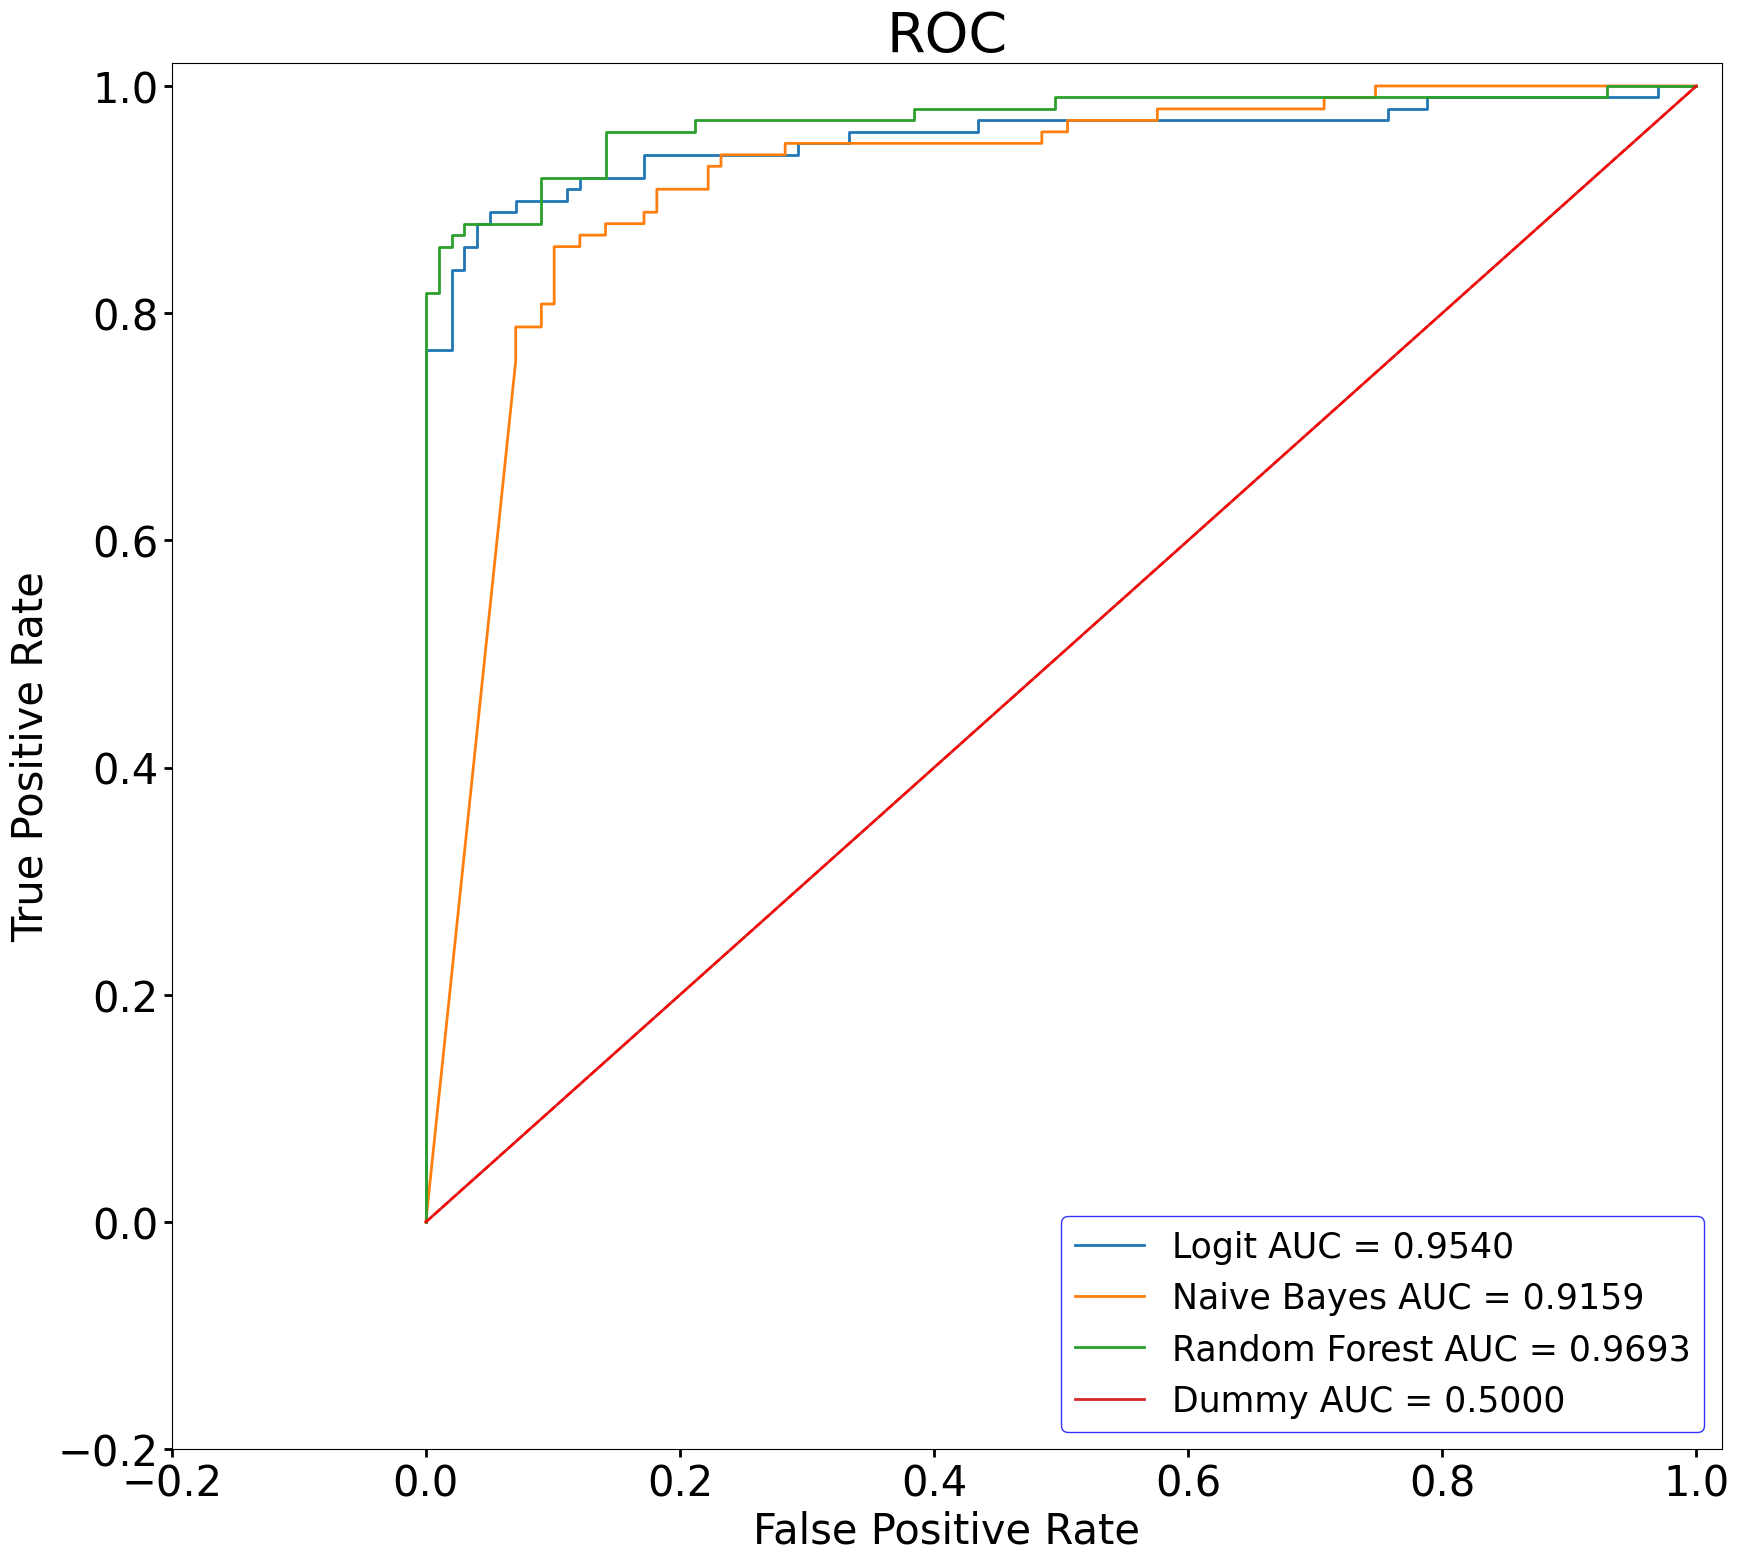

In [22]:
plot_roc_curves(X_val_under, y_val_under, models, model_names)

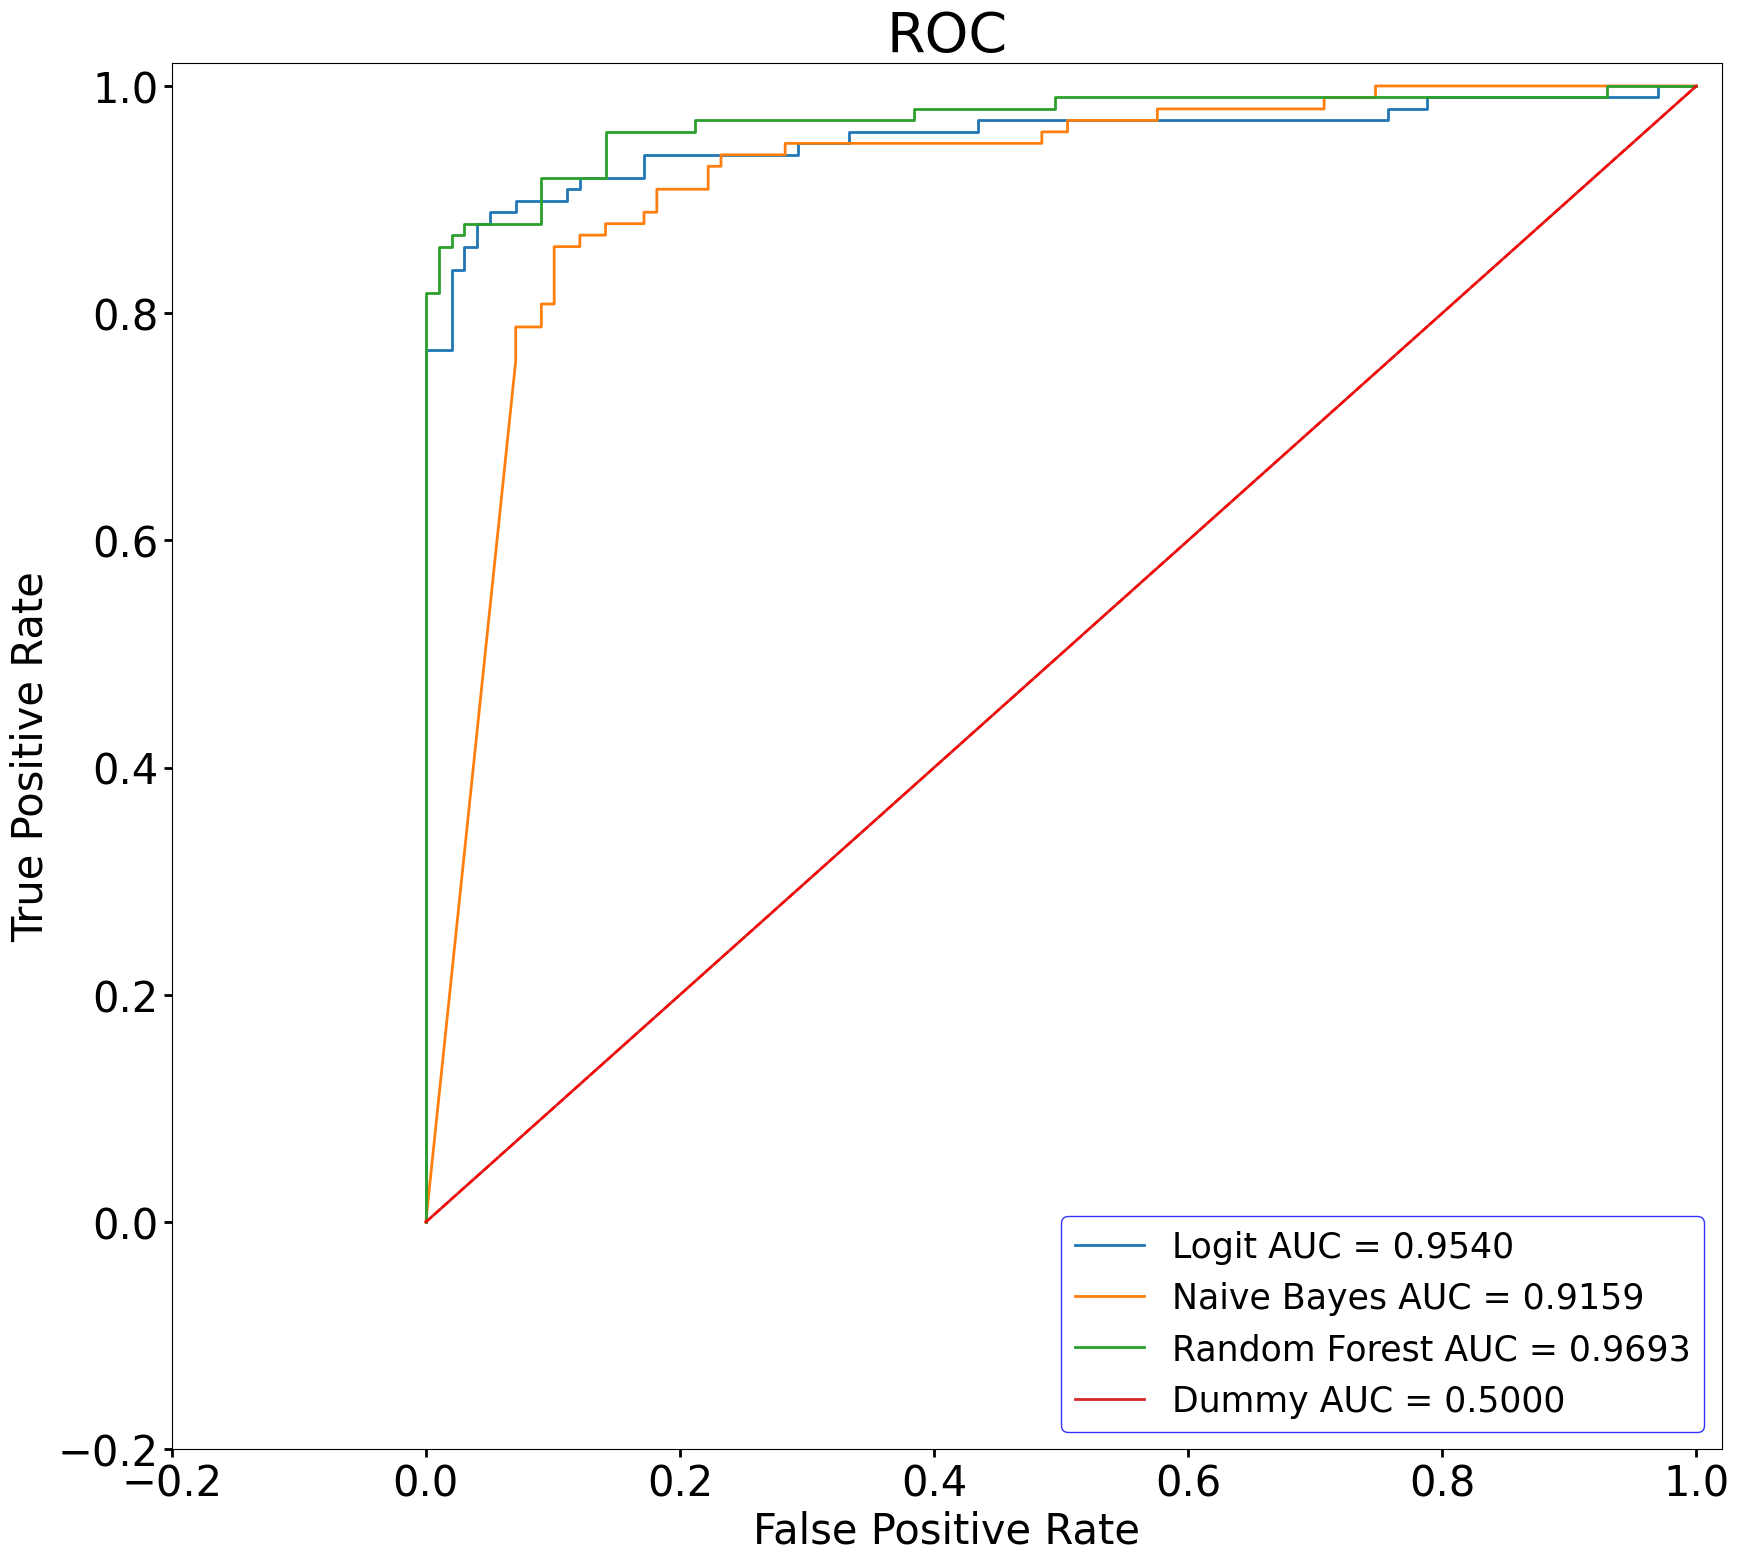

In [23]:
plot_roc_curves(X_val_under, y_val_under, models, model_names)

In [24]:
# Define a function to find the best threshold for a given model
def find_best_threshold(model, num_steps):
    highest_f1 = 0
    best_threshold = 0
    best_acc = 0
    best_rec = 0
    best_pre = 0
    # Iterate over a range of thresholds
    for threshold in np.linspace(0, 1, num_steps):
        # Predict the target variable using the given threshold
        y_predict = (model.predict_proba(X_val_under)[:, 1] >= threshold)
        # Calculate various evaluation metrics
        f1 = f1_score(y_val_under, y_predict)
        acc = accuracy_score(y_val_under, y_predict)
        rec = recall_score(y_val_under, y_predict)
        pre = precision_score(y_val_under, y_predict)
        # Update the best threshold and metrics if F1 score improves
        if f1 > highest_f1:
            best_threshold, highest_f1, best_acc, best_rec, best_pre = \
                threshold, f1, acc, rec, pre
    # Return the best threshold and evaluation metrics
    return best_threshold, highest_f1, best_acc, best_rec, best_pre

In [25]:
models = [logistic_grid, gnb_best, rf_grid]
model_names = ["Logistic Regression", "Naive-Bayes", "Random Forest"]

In [26]:
# Create an empty list to store the results
chart = list()

# Iterate over the models and find the best threshold for each one
for item, name in zip(models, model_names):
    best_thresh, high_f1, high_acc, high_rec, high_pre = find_best_threshold(item, 20)
    # Append the results to the chart list
    chart.append([name, best_thresh, high_f1, high_acc, high_rec, high_pre])

# Create a pandas dataframe from the chart list and display it
chart = pd.DataFrame(chart, columns=['Model', 'Best Threshold', 'F1 Score', 'Accuracy', 'Recall', 'Precision'])
chart.to_csv('model_evaluation_scores.csv')
chart

,Model,Best Threshold,F1 Score,Accuracy,Recall,Precision
0,Logistic Regression,0.842105,0.916667,0.919192,0.888889,0.946237
1,Naive-Bayes,0.052632,0.870466,0.873737,0.848485,0.893617
2,Random Forest,0.473684,0.918919,0.924242,0.858586,0.988372


In [27]:
def confusion_matrix_val(model, threshold=0.5):
    y_predict = (model.predict_proba(X_val_under)[:,1] >= threshold)
    fraud_confusion = confusion_matrix(y_val_under, y_predict)
    plt.figure(dpi=100)
    sns.set(font_scale=1)
    sns.heatmap(fraud_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',xticklabels=['Not Fraaud','Fraud'],
               yticklabels=['Not Fraud','Fraud']);
    TP = fraud_confusion[0][0]
    FP = fraud_confusion[0][1]
    FN = fraud_confusion[1][0]
    TN = fraud_confusion[1][1]
    
    plt.yticks(rotation = 0)
    
    plt.title('Predicted vs Actual', fontname = '.SF Comapact Display', fontsize = 20, pad = 10);
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

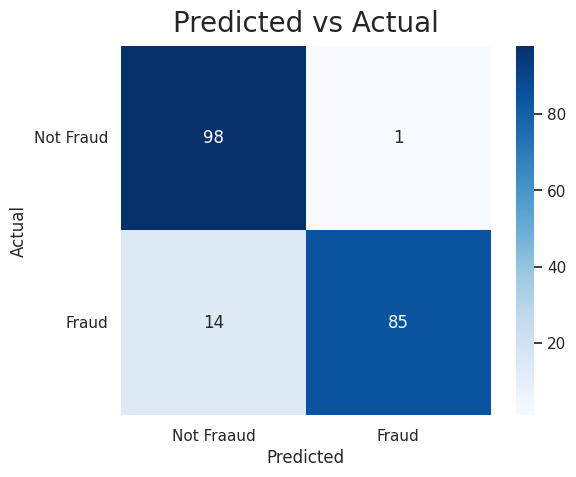

In [29]:
confusion_matrix_val(rf_grid, threshold=0.473)

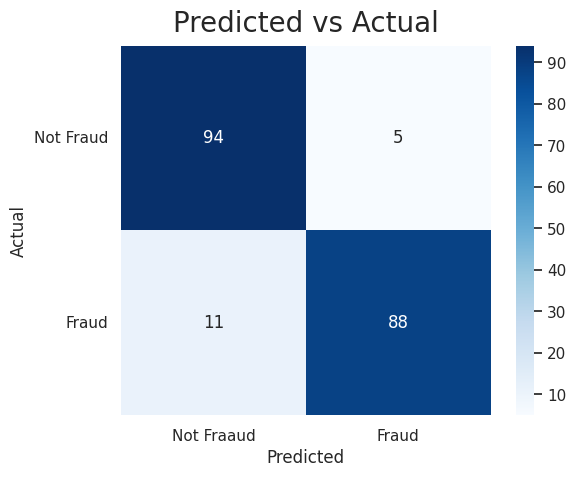

In [30]:
confusion_matrix_val(logistic_grid, threshold=0.842)

In [31]:
def confusion_matrix_test(model, threshold=0.5):
    y_predict = (model.predict_proba(X_test_std)[:,1] >= threshold)
    fraud_confusion = confusion_matrix(y_test, y_predict)
    plt.figure(dpi=100)
    sns.set(font_scale=1)
    sns.heatmap(fraud_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',xticklabels=['Not Fraaud','Fraud'],
               yticklabels=['Not Fraud','Fraud']);
    TP = fraud_confusion[0][0]
    FP = fraud_confusion[0][1]
    FN = fraud_confusion[1][0]
    TN = fraud_confusion[1][1]
    
    plt.yticks(rotation = 0)
    
    plt.title('Predicted vs Actual', fontname = '.SF Comapact Display', fontsize = 20, pad = 10);
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

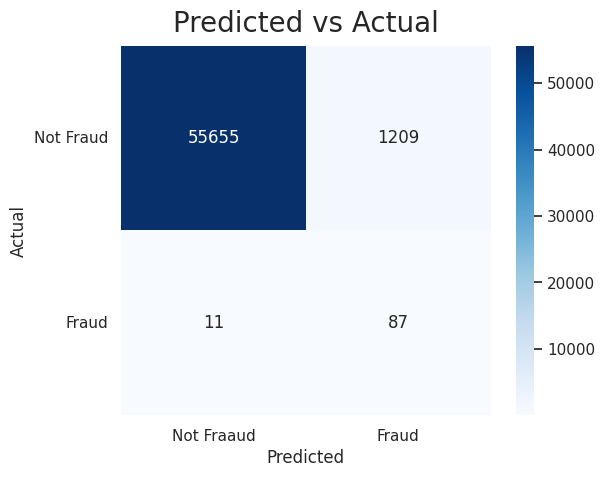

[CV 3/5; 17/24] START max_depth=15, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=500
[CV 3/5; 17/24] END max_depth=15, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=500;, score=0.999 total time=   1.8s
[CV 2/5; 18/24] START max_depth=15, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=700
[CV 2/5; 18/24] END max_depth=15, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=700;, score=0.980 total time=   2.6s
[CV 1/5; 19/24] START max_depth=15, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=500
[CV 1/5; 19/24] END max_depth=15, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=500;, score=0.990 total time=   1.8s
[CV 4/5; 19/24] START max_depth=15, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=500
[CV 4/5; 19/24] END max_depth=15, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=5

In [32]:
confusion_matrix_test(rf_grid, threshold = 0.473)

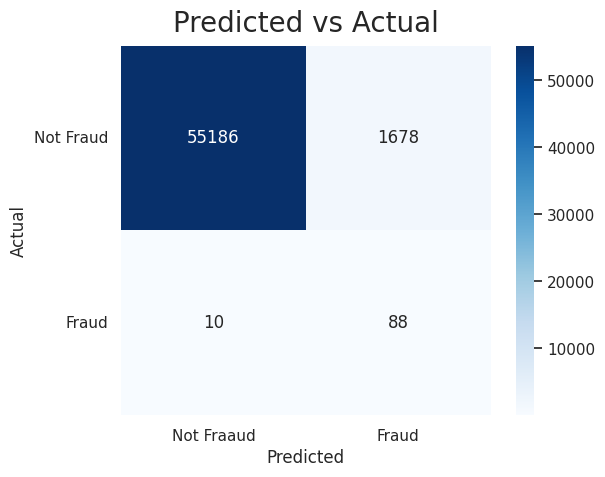

In [33]:
confusion_matrix_test(logistic_grid, threshold = 0.842)